In [17]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix
)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
# Veri Yükleme ve Ayrıştırma
df = pd.read_csv("dataset/train.csv")

X = df.drop("price_range", axis=1)
y = df["price_range"]

In [19]:
print("X şekli:", X.shape)
print("y şekli:", y.shape)
print("\nSınıf dağılımı:")
print(y.value_counts())

X şekli: (2000, 20)
y şekli: (2000,)

Sınıf dağılımı:
price_range
1    500
2    500
3    500
0    500
Name: count, dtype: int64


In [ ]:
# Train/Test Ayırma (Hold-Out, %80 / %20, stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [ ]:
# Özellik Ölçekleme (SVM mesafe tabanlı olduğu için ölçeklendirme şart.)
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
# Hyperparameter Tuning (GridSearchCV ile)
# ek olarak burada da cross validation kullandım.
from sklearn.model_selection import GridSearchCV

param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.001],
    'kernel': ['rbf']
}

grid = GridSearchCV(SVC(), param_grid, cv=3)
grid.fit(X_train_scaled, y_train)

print("\nEn iyi hiperparametreler (GridSearchCV):")
print(grid.best_params_)
print("En iyi CV skoru (train üzeri 3-fold ortalama):", grid.best_score_)

# En iyi bulunan SVM modelini alalım
best_svm = grid.best_estimator_


En iyi hiperparametreler (GridSearchCV):
{'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
En iyi CV skoru (train üzeri 3-fold ortalama): 0.9075007085420898


In [24]:
# Train ve Test Üzerinde Performans (Overfitting kontrolü)
# train_acc ve test_acc birbirine yakınsa, belirgin overfitting yoktur)
train_pred = best_svm.predict(X_train_scaled)
test_pred = best_svm.predict(X_test_scaled)

train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

print("\nTrain accuracy:", train_acc)
print("Test accuracy:", test_acc)



Train accuracy: 0.93875
Test accuracy: 0.93


In [ ]:
# Train accuracy ≈ Test accuracy olduğundan (0.93875 ve 0.93) model eğitim verisini ezberlememiş. 
# Bu nedenle ciddi bir overfitting belirtisi yoktur.

In [25]:
print("\nClassification Report (Test verisi):")
print(classification_report(y_test, test_pred))


Classification Report (Test verisi):
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       100
           1       0.89      0.92      0.91       100
           2       0.91      0.87      0.89       100
           3       0.95      0.96      0.96       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.93       400
weighted avg       0.93      0.93      0.93       400



In [26]:
cm = confusion_matrix(y_test, test_pred)
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[97  3  0  0]
 [ 3 92  5  0]
 [ 0  8 87  5]
 [ 0  0  4 96]]


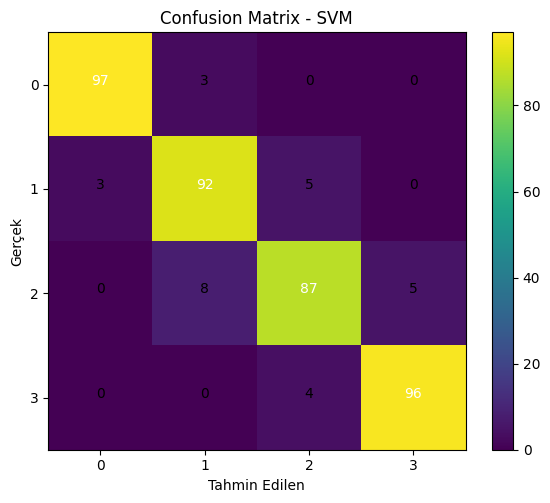

In [27]:
# Confusion Matrix Görselleştirme
plt.figure(figsize=(6, 5))
plt.imshow(cm, interpolation="nearest")
plt.title("Confusion Matrix - SVM")
plt.colorbar()
tick_marks = np.arange(len(np.unique(y)))
plt.xticks(tick_marks, np.unique(y))
plt.yticks(tick_marks, np.unique(y))
plt.xlabel("Tahmin Edilen")
plt.ylabel("Gerçek")

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j, i, format(cm[i, j], 'd'),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black"
        )

plt.tight_layout()
plt.show()